In [281]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import re

## Load data

In [282]:
# Load data from IMDB csv file
data = pd.read_csv('./IMDB.csv')

## Data Preprocessing

Convert HTML to text 

In [ ]:
# Func for handle HTML to text
def preprocessing_text(texts):
    texts = re.sub(r'<.*?>', '', texts)
    texts = re.sub(r'[^a-zA-Z]', ' ', texts)
    return ' '.join(x.lower() for x in texts.split())

# Transform HTML to text
data['review'] = data['review'].apply(lambda x : preprocessing_text(x))

# Encode target
data['sentiment'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

# Look at result
data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is a...,1


In [284]:
# Get info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


Not null values

In [285]:
data.shape

(50000, 2)

In [286]:
data['sentiment'].value_counts()

sentiment
1    25000
0    25000
Name: count, dtype: int64

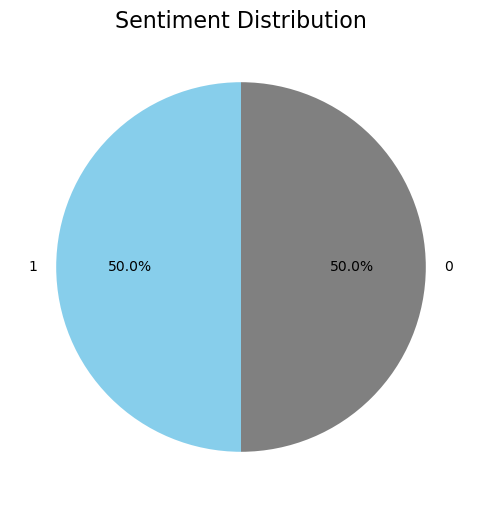

In [287]:
# Plot Sentiment result 
plt.figure(figsize=(8, 6))
plt.pie(data['sentiment'].value_counts(), labels=data['sentiment'].value_counts().index, autopct='%1.1f%%', 
        startangle=90, colors=['skyblue', 'gray'])
plt.title('Sentiment Distribution', fontsize=16)
plt.show()

50/50 result positive and negative valuues

## Train models

In [ ]:
# Split into input features and target variable
X = data['review']  
y = data['sentiment'] 

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


CountVectorizer model

In [ ]:
# Configuring CountVectorizer to skip unnecessary data
count_vectorizer = CountVectorizer(
    stop_words='english',      
    min_df=5,                 
    max_df=0.7,               
    max_features=5000    
)

# Fit the vectorizer on training data
X_train_vectorized = count_vectorizer.fit_transform(X_train)

# Transform test data
X_test_vectorized = count_vectorizer.transform(X_test)

# Check the vocabulary
print(count_vectorizer.get_feature_names_out())

['aaron' 'abandoned' 'abc' ... 'zombie' 'zombies' 'zone']


In [290]:
print(X_test_vectorized.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


TfidfVectorizer model

In [ ]:
# Configure TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',     
    min_df=5,                 
    max_df=0.7,               
    max_features=5000,        
    ngram_range=(1, 2)    
)

# Fit the vectorizer on training data and transform the data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test) 

# Check the vocabulary
print(tfidf_vectorizer.get_feature_names_out())

['abandoned' 'abc' 'abilities' ... 'zombie' 'zombies' 'zone']


In [292]:
print(X_test_tfidf.shape)

(10000, 5000)


Create Pipeline

In [293]:
# Create MultinomialNB
mnb = MultinomialNB()

# Bag of Words (BOW) pipeline
bow_pipeline = Pipeline([
    ('vectorizer', count_vectorizer), 
    ('classifier', mnb) 
])

# TF-IDF pipeline
tfidf_pipeline = Pipeline([
    ('vectorizer', tfidf_vectorizer),
    ('classifier', mnb) 
])

## Evaluate data

In [294]:
# BOW model
bow_pipeline.fit(X_train, y_train)
bow_predictions = bow_pipeline.predict(X_test)
print("BOW Accuracy:", accuracy_score(y_test, bow_predictions))
print("BOW Classification Report:\n", classification_report(y_test, bow_predictions))
print('Confusion Matrix:')
pd.crosstab(y_test, bow_predictions, rownames=["Actual"], colnames=["Predicted"])

BOW Accuracy: 0.8466
BOW Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.85      0.85      4961
           1       0.85      0.84      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:


Predicted,0,1
Actual,,
0,4232,729
1,805,4234


In [295]:
# TF-IDF model
tfidf_pipeline.fit(X_train, y_train)
tfidf_predictions = tfidf_pipeline.predict(X_test)
print("TF-IDF Accuracy:", accuracy_score(y_test, tfidf_predictions))
print("TF-IDF Classification Report:\n", classification_report(y_test, tfidf_predictions))
print('Confusion Matrix:')
pd.crosstab(y_test, tfidf_predictions, rownames=["Actual"], colnames=["Predicted"])

TF-IDF Accuracy: 0.8533
TF-IDF Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.84      0.85      4961
           1       0.85      0.87      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000

Confusion Matrix:


Predicted,0,1
Actual,,
0,4162,799
1,668,4371


## Conclusion:
Both models achieved an accuracy of 85%, which is a solid indicator of their ability to differentiate between positive and negative sentiments in reviews. This suggests the chosen preprocessing and feature extraction techniques effectively captured the sentiment-related information from the text. The similar performance of CountVectorizer (BOW) and TfidfVectorizer implies that in this dataset, simple word frequency counts (BOW) and term importance weighting (TF-IDF) both capture sufficient information to make accurate predictions. The Multinomial Naive Bayes classifier is well-suited for text data and works effectively with both feature extraction methods. Its strong performance highlights its suitability for this task.